# MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [1]:
import os
os.chdir('/content/')
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz

--2019-10-26 14:55:32--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz’

mnist.pkl.gz        100%[===================>]  15.42M  4.16MB/s    in 4.8s    

2019-10-26 14:55:37 (3.24 MB/s) - ‘mnist.pkl.gz’ saved [16168813/16168813]



In [0]:
%matplotlib inline
from fastai.basics import *

In [0]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

In [4]:
x_train[0].shape

(784,)

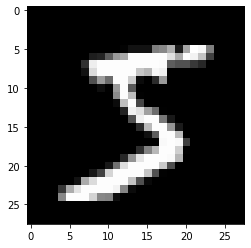

In [5]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")

In [6]:
# convert to tensors
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape # n = no of rows, c = no of columns
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```


Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [0]:
# Create a databunch with mini batch size
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [8]:
# next iteration to check if the databunch is giving data as mini batch size
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [0]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True) # fn = ax+b

    def forward(self, xb): return self.lin(xb) # xb = mini batch of x

In [0]:
model = Mnist_Logistic().cuda() # cuda() places the data and weights on to GPU

In [13]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [14]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [15]:
model(x).shape

torch.Size([64, 10])

In [17]:
[p.shape for p in model.parameters()] # parameters contains weight and bias matrices respectively

[torch.Size([10, 784]), torch.Size([10])]

In [0]:
lr  = 2e-2

In [0]:
loss_func = nn.CrossEntropyLoss() # predict classification


Code from lesson2-sgd for update function
```
def update():
    y_hat = x@a
    loss = mse(y, y_hat)
    if t % 10 == 0: print(loss)
    loss.backward()
    with torch.no_grad():
        a.sub_(lr * a.grad)
        a.grad.zero_()
```



<u>***Weight decay***</u>
$$ 
w_{t} = w_{t-1} - lr * \frac{d \mathbf{L}}{d \mathbf{w_{t-1}}}
$$
<br>
$$
L(X,W) = LossFunc(Model(X,W), y) + wd * \sum_{}^{}w^2 
$$

<p> $wd * \sum_{}^{}w^2$ is L2 Regularization </p>

In [0]:
def update(x, y, lr):
    wd = 1e-5
    y_hat = model(x)
    #weight decay using SGD
    w2 = 0.
    for p in model.parameters(): 
      w2 += (p**2).sum()
    # add weight decay to regular loss
    loss = loss_func(y_hat, y) + wd*w2
    loss.backward()
    with torch.no_grad():
      for p in model.parameters():
        p.sub_(lr * p.grad)
        p.grad.zero_()
    return loss.item() #item() converts tensor to normal number

In [0]:
# calculate losses for all mini batches 
losses = [update(x,y,lr) for x,y in data.train_dl]

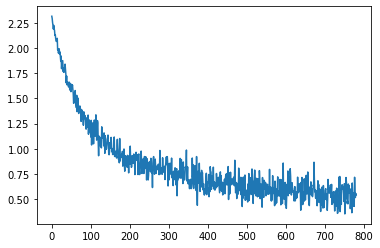

In [23]:
plt.plot(losses)

In [0]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [0]:
model = Mnist_NN().cuda()

In [0]:
# calculate losses for all mini batches 
losses = [update(x,y,lr) for x,y in data.train_dl]

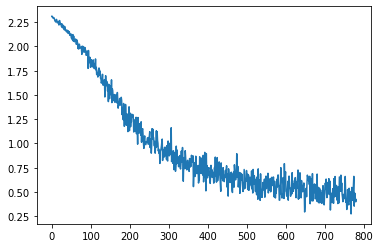

In [27]:
plt.plot(losses)

In [0]:
model = Mnist_NN().cuda()

In [0]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [0]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

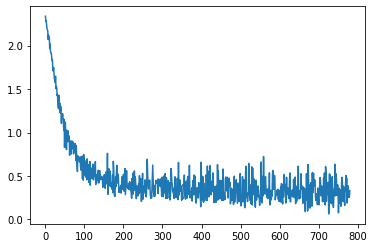

In [35]:
plt.plot(losses)

In [0]:
optim.SGD(model.parameters(), lr) # SGD
optim.SGD(model.parameters(), lr, momentum=0.9) # SGD with momentum
optim.RMSprop(model.parameters(), lr) #RMSprop
optim.Adam(model.parameters(), lr); # Adam = RMSprop + momentum

In [0]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


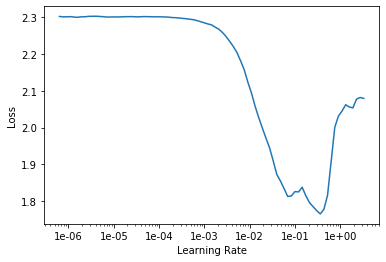

In [41]:
learn.lr_find()
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.149656,0.128162,0.963900,00:05


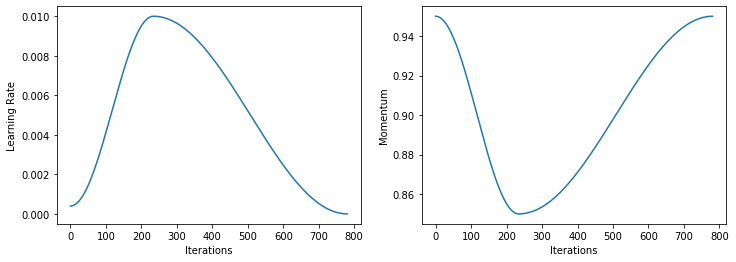

In [43]:
learn.recorder.plot_lr(show_moms=True)

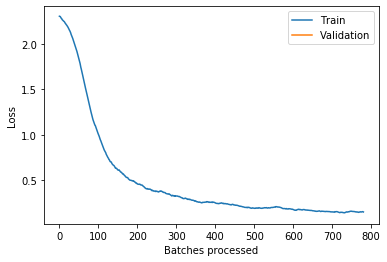

In [44]:
learn.recorder.plot_losses()